## Load useful libraries

In [1]:
import numpy as np
from skimage import io
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback


import h5py
import os

## Parameters

In [2]:
prepared_dataset = './data/mnist-noisy.h5'
model_directory  = './models'

latent_dim       = 10

train_prop       = .8
batch_size       = 128
epochs           = 30
fit_verbosity    = 1

## Retrieve the dataset

In [3]:
def reload_prepared_dataset(train_prop=0.8, shuffle=True, seed=False, filename='./data/mnist-noisy.h5'):

    # Load saved dataset
    with  h5py.File(filename,'r') as f:
        clean_data  = f['clean_data'][:]
        noisy_data  = f['noisy_data'][:]
        class_data  = f['class_data'][:]
    print('Loaded.')

    # ---- Shuffle
    #
    if shuffle:
        p = np.random.permutation(len(clean_data))
        clean_data, noisy_data, class_data = clean_data[p], noisy_data[p], class_data[p]
        print('Shuffled.')

    # ---- Split
    #
    n=int(len(clean_data)*train_prop)
    clean_train, clean_test = clean_data[:n], clean_data[n:]
    noisy_train, noisy_test = noisy_data[:n], noisy_data[n:]
    class_train, class_test = class_data[:n], class_data[n:]
    print(f'splited ({train_prop}).') 


    print('clean_train shape is : ', clean_train.shape)
    print('clean_test  shape is : ', clean_test.shape)
    print('noisy_train shape is : ', noisy_train.shape)
    print('noisy_test  shape is : ', noisy_test.shape)
    print('class_train shape is : ', class_train.shape)
    print('class_test  shape is : ', class_test.shape)
    return  clean_train,clean_test, noisy_train,noisy_test, class_train,class_test

In [4]:
clean_train,clean_test, noisy_train,noisy_test, class_train, class_test= reload_prepared_dataset(shuffle = True, filename=prepared_dataset )

Loaded.
Shuffled.
splited (0.8).
clean_train shape is :  (56000, 28, 28, 1)
clean_test  shape is :  (14000, 28, 28, 1)
noisy_train shape is :  (56000, 28, 28, 1)
noisy_test  shape is :  (14000, 28, 28, 1)
class_train shape is :  (56000,)
class_test  shape is :  (14000,)


## Build AE model 

In [5]:
# Encoder

inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 16)                50192     
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
Total params: 69,178
Trainable params: 69,178
Non-trainable

2022-08-17 10:44:57.419011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 10:44:57.427842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 10:44:57.428343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 10:44:57.429309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
# Decoder

inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 3136)              34496     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [7]:
# AE

inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name="ae")

ae.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')

In [8]:
# callbacks


filename = model_directory + '/best_model.h5'
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath=filename, verbose=0, save_best_only=True)

In [9]:
history = ae.fit(noisy_train, clean_train,
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = fit_verbosity,
                 validation_data = (noisy_test, clean_test),
                 callbacks=[callback_bestmodel])

Epoch 1/30


2022-08-17 10:44:59.420318: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-17 10:44:59.815533: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


438/438 [==============================] - 4s 5ms/step - loss: 0.2676 - val_loss: 0.2130
Epoch 2/30
438/438 [==============================] - 2s 5ms/step - loss: 0.1872 - val_loss: 0.1739
Epoch 3/30
438/438 [==============================] - 2s 5ms/step - loss: 0.1691 - val_loss: 0.1642
Epoch 4/30
438/438 [==============================] - 2s 5ms/step - loss: 0.1606 - val_loss: 0.1576
Epoch 5/30
438/438 [==============================] - 2s 5ms/step - loss: 0.1558 - val_loss: 0.1548
Epoch 6/30
438/438 [==============================] - 2s 5ms/step - loss: 0.1532 - val_loss: 0.1537
Epoch 7/30
438/438 [==============================] - 3s 6ms/step - loss: 0.1512 - val_loss: 0.1524
Epoch 8/30
438/438 [==============================] - 2s 5ms/step - loss: 0.1500 - val_loss: 0.1509
Epoch 9/30
438/438 [==============================] - 2s 5ms/step - loss: 0.1487 - val_loss: 0.1505
Epoch 10/30
438/438 [==============================] - 2s 5ms/step - loss: 0.1478 - val_loss: 0.1503
Epoch 11/3

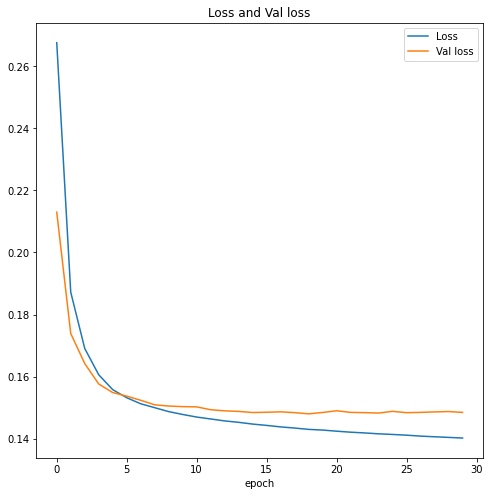

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, val_loss, label='Val loss')
plt.legend(loc='upper right')
plt.xlabel("epoch")
plt.title('Loss and Val loss')
plt.show()

In [11]:
def plot(images):
    for i in range(7):
        plt.subplot(170 + 1 + i)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    # show the figure
    plt.show()

In [12]:
model = keras.models.load_model(f'{model_directory}/best_model.h5')

In [13]:
denoised_test = model.predict(noisy_test)

print('Denoised images   (denoised_test) shape : ',denoised_test.shape)

438/438 [==============================] - 1s 1ms/step
Denoised images   (denoised_test) shape :  (14000, 28, 28, 1)


Noisy test images (input):


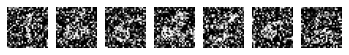

Denoised images (output):


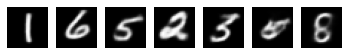

Real test images :


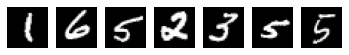

In [14]:
i=random.randint(0,len(denoised_test)-7)
j=i+7

print('Noisy test images (input):')
plot(noisy_test[i:j])

print('Denoised images (output):')
plot(denoised_test[i:j])

print('Real test images :')
plot(clean_test[i:j])